<a href="https://colab.research.google.com/github/arjan-hada/protein-variant-prediction/blob/master/00_protein_seq2fxn_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets umap-learn &> /dev/null

# Learning sequence-to-function relationship using language models

Protein engineering is like jazzing up Mother Nature's enzymes – we tweak them for stability, catalytic action, and substrate specificity. To cook up these cool proteins, we've to crack the code linking a protein's sequence to its superpowers. Protein sequence-to-function mapping is a wild ride – think thousands of molecular tango moves, coupled over multiple lengths and timescales.

Enter deep mutational scanning (DMS) experiments – these efficiently map tens of thousands of protein variations to corresponding phenotypic changes. Supervised machine learning steps in, learning the ropes of mapping specific protein properties directly from real-life sequence–function showdowns. The learned models like these have been shown to craft brand-new proteins that outshine anything nature cooked up. It's like having an AI protein designer in the lab, pushing the boundaries of what's naturally possible.


In this and following notebook, we will dive into training a variant predictor i.e. predicting the biological activity of mutations of a protein, using embeddings from Protein Language Model (PLM).

**Goals**

- Prepare the DMS data for machine learning
- Obtain an embedding (fixed-dimensional vector representation) for each mutated sequence from PLM.
- Split the data into train and test set
- Train a regression model in sklearn that can predict the "fitness" score given the embedding.

## The dataset

To build our protein sequence-to-function predictor we will use the [DMS data](https://raw.githubusercontent.com/churchlab/aav_rep_scan/master/analysis/selection_values/rep7868_selection_values_barcode.csv) from [rep mutagenesis scan paper published in 2023 from George M. Church lab](https://doi.org/10.7554/eLife.87730.1). This paper examines the mutational landscape of Rep protein by assaying the effects of all 39,297 possible single codon mutations to the adeno-associated virus 2(AAV2) rep gene on AAV2 production. The AAV Rep proteins, indispensable for genome replication and packaging, present a favorable engineering target for improving of recombinant adeno-associated virus (rAAV) production for therapeutic purposes.

The data consists of the mutated Rep78 sequence, where a single aminoacid residue is mutated (swapped with another amino acid) and the target value that describes the fitness of the mutation.



In [ ]:
# Import libraries
from pathlib import Path
import os
import pickle

import numpy as np
import pandas as pd
import re
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)

In [ ]:
# Wild type sequence of Rep78 from AAV2
rep78_seq = 'MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDECYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKENQNPNSDAPVIRSKTSARYMELVGWLVDKGITSEKQWIQEDQASYISFNAASNSRSQIKAALDNAGKIMSLTKTAPDYLVGQQPVEDISSNRIYKILELNGYDPQYAASVFLGWATKKFGKRNTIWLFGPATTGKTNIAEAIAHTVPFYGCVNWTNENFPFNDCVDKMVIWWEEGKMTAKVVESAKAILGGSKVRVDQKCKSSAQIDPTPVIVTSNTNMCAVIDGNSTTFEHQQPLQDRMFKFELTRRLDHDFGKVTKQEVKDFFRWAKDHVVEVEHEFYVKKGGAKKRPAPSDADISEPKRVRESVAQPSTSDAEASINYADRYQNKCSRHVGMNLMLFPCRQCERMNQNSNICFTHGQKDCLECFPVSESQPVSVVKKAYQKLCYIHHIMGKVPDACTACDLVNVDLDDCIFEQ'
len(rep78_seq)

621

In the paper rep open reading frame with a M225G mutation was introduced to prevent expression of the smaller Rep proteins. The rep seuqence with this substitution was considered as wild-type sequence.

In [ ]:
# change M225G. This will be considered wild type sequence from here on. Python string is zero-indexed
wt_seq = rep78_seq[:224] + 'G' + rep78_seq[225:]
len(wt_seq) # ensure length remains same after substitution

621

In [ ]:
# Link to csv file with fitness data from paper
rep7868_selection_values_barcode = 'https://raw.githubusercontent.com/churchlab/aav_rep_scan/master/analysis/selection_values/rep7868_selection_values_barcode.csv'

In [ ]:
# Read the fitness data into a pandas dataframe
# a, b = fitness values for transfection duplicates
fitness_data = pd.read_csv(rep7868_selection_values_barcode)
fitness_data

,abs_pos,aa,codon,lib_type,barcode,is_wt,a,b
0,1,*,TAA,del,GTGAGACTGACACACTGTCT,0,0.471768,0.289412
1,1,*,TAA,del,TCAGACTCTGACTGAGACAG,0,0.928537,0.656928
2,1,*,TAA,sub,ACTGAGAGAGTGACAGACTG,0,0.609253,0.231558
3,1,*,TAA,sub,TCTGAGTCTCACACTCACAG,0,0.497817,0.493451
4,1,*,TAG,sub,GACACTCAGAGAGACTGAGT,0,0.442826,0.194076
...,...,...,...,...,...,...,...,...
80959,622,W,TGG,sub,TCTGACACACTGACACTGAC,0,0.729599,0.787785
80960,622,Y,TAC,sub,CTGAGTGTCAGACTGACTCA,0,0.902470,1.056134
80961,622,Y,TAC,sub,TCAGTGTGTGACAGACTGTC,0,0.714219,0.628245
80962,622,Y,TAT,sub,AGACAGACACAGTGTCTCTG,0,0.000000,0.000000


Brief description of the columns in the dataset:

**`abs_pos`**: Indicates amino acid position where the mutation has been made.

**`aa`**: Represents the substituted amino acid at a given position. For example, * represents substitution with a stop codon, and Y represents substitution with a codon coding for amino acid Y.

**`codon`**: A nucleotide triplet that codes for a given amino acid. For instance, TAA codes for *, and TAC codes for amino acid Y.

**`lib_type`**: Indicates whether a mutation is a substitution (sub) or a deletion (del).

**`barcode`**: Represents each unique variant or replicate. Fitness is essentially determined as the normalized frequency of barcode counts.

**`is_wt`**: Indicates whether the substitution is wildtype or not. A value of 0 represents not wildtype.

**`a`**: Reflects the fitness value for first biological replicate.

**`b`**: Reflects the fitness value for second biological replicate.

## Data processing

In this segment, we will dive into Exploratory Data Analysis (EDA) and transform the data into a format amenable for supervised machine learning. Our goal is to create a pair of lists: `sequences` and `fitness`. `sequences` will be a list of protein sequences. `fitness` will be a list of score for each protein sequence. 'fitness` refers to quantitative value of property of protein sequence related to function that the experimenter is interested in optimizing.

In [ ]:
# Remove rows containing stop codon (truncated proteins smaller than 621 AA)
# And remove rows with data for 622 aminoacid position (rep78 is only 621 AA long)
fitness_data_sub = fitness_data.loc[-((fitness_data['aa'] == '*')|(fitness_data['abs_pos'] == 622))].copy()
fitness_data_sub

,abs_pos,aa,codon,lib_type,barcode,is_wt,a,b
8,1,A,GCA,sub,CAGTGTCACAGACTGTCTCA,0,0.846289,1.032180
9,1,A,GCA,sub,CAGTGTCAGAGACTCACTCT,0,0.511128,1.132121
10,1,A,GCC,sub,GTCTCAGAGACACAGTGTGT,0,0.675473,1.059506
11,1,A,GCC,sub,TGACTCAGAGTCTCACAGAG,0,0.518410,0.789974
12,1,A,GCG,sub,ACTGTCACACACTCTCTGAG,0,1.064481,0.725189
...,...,...,...,...,...,...,...,...
80831,621,W,TGG,sub,GACAGTCACTCAGTGAGACT,0,0.805424,0.843358
80832,621,Y,TAC,sub,CTGACTGTGTCTCTCACACT,0,0.690574,0.691127
80833,621,Y,TAC,sub,GACAGACTCTCTCTGTGTGA,0,0.950902,0.712097
80834,621,Y,TAT,sub,GACTGTCAGTCTCTCTCTGA,0,0.846289,1.251792


In [ ]:
# check if any fitness values are inf
fitness_data_sub.loc[(fitness_data_sub['a'] == np.inf)|(fitness_data_sub['b'] == np.inf)].head()

,abs_pos,aa,codon,lib_type,barcode,is_wt,a,b
4784,38,G,GGG,sub,AGACACTGAGTGAGAGAGTC,0,inf,inf
21505,166,S,TCA,sub,CTGAGAGTGAGACACACAGA,0,inf,inf


In [ ]:
# number of rows where fitness values are inf
len(fitness_data_sub.loc[(fitness_data_sub['a'] == np.inf)|(fitness_data_sub['b'] == np.inf)])

2

In [ ]:
# check if any fitness values are NaN
fitness_data_sub.loc[(fitness_data_sub['a'] == np.nan)|(fitness_data_sub['b'] == np.nan)]

,abs_pos,aa,codon,lib_type,barcode,is_wt,a,b


In [ ]:
# Replacing infinite with nan
fitness_data_sub.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
fitness_data_sub.dropna(inplace=True)

In [ ]:
fitness_data_sub # 40 rows containing infinite fitness values should be dropped

,abs_pos,aa,codon,lib_type,barcode,is_wt,a,b
8,1,A,GCA,sub,CAGTGTCACAGACTGTCTCA,0,0.846289,1.032180
9,1,A,GCA,sub,CAGTGTCAGAGACTCACTCT,0,0.511128,1.132121
10,1,A,GCC,sub,GTCTCAGAGACACAGTGTGT,0,0.675473,1.059506
11,1,A,GCC,sub,TGACTCAGAGTCTCACAGAG,0,0.518410,0.789974
12,1,A,GCG,sub,ACTGTCACACACTCTCTGAG,0,1.064481,0.725189
...,...,...,...,...,...,...,...,...
80831,621,W,TGG,sub,GACAGTCACTCAGTGAGACT,0,0.805424,0.843358
80832,621,Y,TAC,sub,CTGACTGTGTCTCTCACACT,0,0.690574,0.691127
80833,621,Y,TAC,sub,GACAGACTCTCTCTGTGTGA,0,0.950902,0.712097
80834,621,Y,TAT,sub,GACTGTCAGTCTCTCTCTGA,0,0.846289,1.251792


In [ ]:
# Group fitness values for a and b (transfection replicates)
# by a combination of abs_pos (aminoacid position) and aa (aminoacid)
fitness_data_grouped = fitness_data_sub.groupby(['abs_pos', 'aa'], as_index=False).agg({'a': lambda x: list(x),
                                                                                        'b': lambda x: list(x)})
fitness_data_grouped

,abs_pos,aa,a,b
0,1,A,"[0.846288745135642, 0.5111275214408407, 0.6754...","[1.0321796826964167, 1.1321210764812213, 1.059..."
1,1,C,"[0.4204436063464981, 0.5026736592340829, 0.381...","[0.8655702836113958, 0.2399670461068991, 1.113..."
2,1,D,"[0.3147959865123928, 0.5590239058996285, 1.036...","[0.2239188297881254, 0.1296074941648796, 0.396..."
3,1,E,"[0.7982236642760111, 0.5118219881819288, 0.920...","[1.9689414343438607, 0.4762955710543403, 0.510..."
4,1,F,"[0.7435612728322876, 0.4087579206132755, 0.611...","[0.807728060386305, 0.4996692588497194, 0.6489..."
...,...,...,...,...
12394,621,S,"[0.932344002063711, 2.0666804201404507, 1.4131...","[0.7359317371076232, 1.69648768539362, 0.92061..."
12395,621,T,"[0.6892849507892106, 1.4358430931469086, 1.540...","[2.1060294671492623, 0.9398272684590618, 0.476..."
12396,621,V,"[0.7822837139909294, 1.1420505557193783, 1.292...","[0.2852112966831767, 0.6426072925872238, 1.371..."
12397,621,W,"[0.7368458657141186, 0.8054241354743774]","[0.6430995888342872, 0.8433580430015688]"


In [ ]:
# New `fitness_values` column contains all the fitness values for a given aminoacid substitution at a position
fitness_data_grouped['fitness_values'] = fitness_data_grouped["a"] + fitness_data_grouped["b"]
fitness_data_grouped.head()

,abs_pos,aa,a,b,fitness_values
0,1,A,"[0.846288745135642, 0.5111275214408407, 0.6754...","[1.0321796826964167, 1.1321210764812213, 1.059...","[0.846288745135642, 0.5111275214408407, 0.6754..."
1,1,C,"[0.4204436063464981, 0.5026736592340829, 0.381...","[0.8655702836113958, 0.2399670461068991, 1.113...","[0.4204436063464981, 0.5026736592340829, 0.381..."
2,1,D,"[0.3147959865123928, 0.5590239058996285, 1.036...","[0.2239188297881254, 0.1296074941648796, 0.396...","[0.3147959865123928, 0.5590239058996285, 1.036..."
3,1,E,"[0.7982236642760111, 0.5118219881819288, 0.920...","[1.9689414343438607, 0.4762955710543403, 0.510...","[0.7982236642760111, 0.5118219881819288, 0.920..."
4,1,F,"[0.7435612728322876, 0.4087579206132755, 0.611...","[0.807728060386305, 0.4996692588497194, 0.6489...","[0.7435612728322876, 0.4087579206132755, 0.611..."


In [ ]:
len(fitness_data_grouped['fitness_values'][0]) == len(fitness_data_grouped["a"][0]) + len(fitness_data_grouped["b"][0])

True

In [ ]:
def is_wt_aa(wt_seq, abs_pos, aa):
    """
    If a given aminoacid substitution is wildtype return 1, else 0.
    Example M1M will return 1, M1A will return 0
    """
    return int(wt_seq[abs_pos-1] == aa)

def aa_mutations(wt_seq, abs_pos, aa):
    """
    Return mutation string.
    Example M1A.
    """
    return wt_seq[abs_pos-1] + str(abs_pos) + aa

In [ ]:
# If a given aminoacid substitution is same as wildtype return 1, else 0.
fitness_data_grouped['is_wt_aa'] = fitness_data_grouped.apply(lambda x: is_wt_aa(wt_seq, x['abs_pos'], x['aa']),
                                                               axis=1)
# Return mutation string, an example M1A.
fitness_data_grouped['aa_mutations'] = fitness_data_grouped.apply(lambda x: aa_mutations(wt_seq, x['abs_pos'], x['aa']),
                                                               axis=1)

In [ ]:
fitness_data_grouped

,abs_pos,aa,a,b,fitness_values,is_wt_aa,aa_mutations
0,1,A,"[0.846288745135642, 0.5111275214408407, 0.6754...","[1.0321796826964167, 1.1321210764812213, 1.059...","[0.846288745135642, 0.5111275214408407, 0.6754...",0,M1A
1,1,C,"[0.4204436063464981, 0.5026736592340829, 0.381...","[0.8655702836113958, 0.2399670461068991, 1.113...","[0.4204436063464981, 0.5026736592340829, 0.381...",0,M1C
2,1,D,"[0.3147959865123928, 0.5590239058996285, 1.036...","[0.2239188297881254, 0.1296074941648796, 0.396...","[0.3147959865123928, 0.5590239058996285, 1.036...",0,M1D
3,1,E,"[0.7982236642760111, 0.5118219881819288, 0.920...","[1.9689414343438607, 0.4762955710543403, 0.510...","[0.7982236642760111, 0.5118219881819288, 0.920...",0,M1E
4,1,F,"[0.7435612728322876, 0.4087579206132755, 0.611...","[0.807728060386305, 0.4996692588497194, 0.6489...","[0.7435612728322876, 0.4087579206132755, 0.611...",0,M1F
...,...,...,...,...,...,...,...
12394,621,S,"[0.932344002063711, 2.0666804201404507, 1.4131...","[0.7359317371076232, 1.69648768539362, 0.92061...","[0.932344002063711, 2.0666804201404507, 1.4131...",0,Q621S
12395,621,T,"[0.6892849507892106, 1.4358430931469086, 1.540...","[2.1060294671492623, 0.9398272684590618, 0.476...","[0.6892849507892106, 1.4358430931469086, 1.540...",0,Q621T
12396,621,V,"[0.7822837139909294, 1.1420505557193783, 1.292...","[0.2852112966831767, 0.6426072925872238, 1.371...","[0.7822837139909294, 1.1420505557193783, 1.292...",0,Q621V
12397,621,W,"[0.7368458657141186, 0.8054241354743774]","[0.6430995888342872, 0.8433580430015688]","[0.7368458657141186, 0.8054241354743774, 0.643...",0,Q621W


### EDA of fitness values

In [ ]:
# All the fitness values for wildtype sequences
fitness_values_wt = np.concatenate(fitness_data_grouped.query('is_wt_aa == 1')['fitness_values'].values)
# Fitness values for all the mutant sequences
fitness_values_mutant = np.concatenate(fitness_data_grouped.query('is_wt_aa == 0')['fitness_values'].values)

<ipython-input-20-3f3eaa7a0a04>:2: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(fitness_values_wt), label = "wildtype sequences", kde=True)
<ipython-input-20-3f3eaa7a0a04>:3: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(fitness_values_mutant), label = "mutant sequences", kde=True)


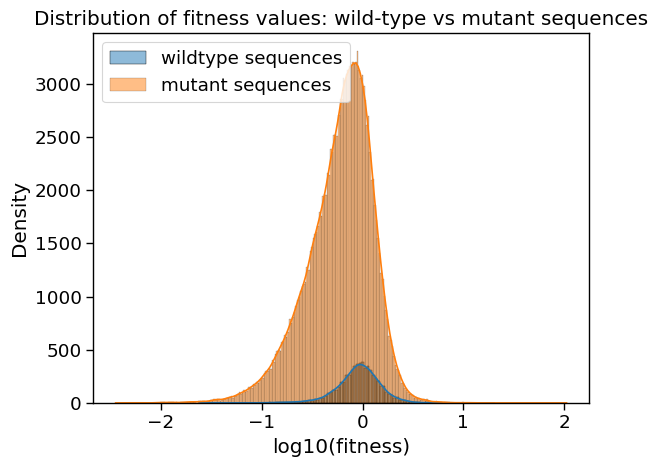

In [ ]:
# Density plot of fitness values for wildtype vs mutants
sns.histplot(np.log10(fitness_values_wt), label = "wildtype sequences", kde=True)
sns.histplot(np.log10(fitness_values_mutant), label = "mutant sequences", kde=True)
plt.xlabel('log10(fitness)')
plt.ylabel('Density')
plt.title("Distribution of fitness values: wild-type vs mutant sequences")
plt.legend();

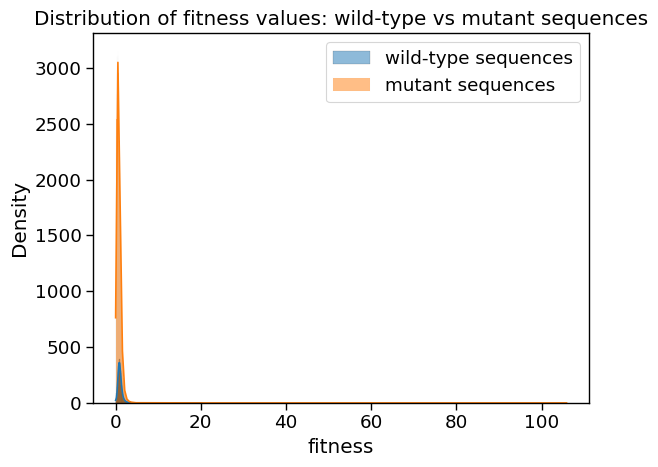

In [ ]:
# Density plot of fitness values for wildtype vs mutants
sns.histplot(fitness_values_wt, label = "wild-type sequences", kde=True)
sns.histplot(fitness_values_mutant, label = "mutant sequences", kde=True)
plt.xlabel('fitness')
plt.ylabel('Density')
plt.legend()
plt.title("Distribution of fitness values: wild-type vs mutant sequences");

In [ ]:
# Find the row with max wildtype fitness value
fitness_data_sub.loc[(fitness_data_sub['a'] == max(fitness_values_wt))|
                     (fitness_data_sub['b'] == max(fitness_values_wt))]

,abs_pos,aa,codon,lib_type,barcode,is_wt,a,b
16466,128,L,CTA,sub,CACACAGTCTGACTGACTGT,0,1.493451,20.204368


In [ ]:
# Find the row with max mutant fitness value
fitness_data_sub.loc[(fitness_data_sub['a'] == max(fitness_values_mutant))|
                     (fitness_data_sub['b'] == max(fitness_values_mutant))]

,abs_pos,aa,codon,lib_type,barcode,is_wt,a,b
7893,62,P,CCT,sub,AGACAGAGAGAGAGTCTGTC,0,2.613539,105.853321


### Getting data columns required for supervised training

In [ ]:
# Put all the fitness values for wildtype sequence in one row and make a new dataframe

# subset all mutant fitness values
fitness_by_mutation = fitness_data_grouped.query('is_wt_aa == 0')[['aa_mutations', 'fitness_values']]
fitness_by_mutation.loc[-1] = ["", fitness_values_wt] # insert wildtype fitness values in top row
fitness_by_mutation = fitness_by_mutation.sort_index()  # sorting by index
fitness_by_mutation

,aa_mutations,fitness_values
-1,,"[0.4618301444042837, 1.8924231230151436, 0.952..."
0,M1A,"[0.846288745135642, 0.5111275214408407, 0.6754..."
1,M1C,"[0.4204436063464981, 0.5026736592340829, 0.381..."
2,M1D,"[0.3147959865123928, 0.5590239058996285, 1.036..."
3,M1E,"[0.7982236642760111, 0.5118219881819288, 0.920..."
...,...,...
12394,Q621S,"[0.932344002063711, 2.0666804201404507, 1.4131..."
12395,Q621T,"[0.6892849507892106, 1.4358430931469086, 1.540..."
12396,Q621V,"[0.7822837139909294, 1.1420505557193783, 1.292..."
12397,Q621W,"[0.7368458657141186, 0.8054241354743774, 0.643..."


In [ ]:
# Inspired from https://github.com/ElArkk/jax-unirep/blob/master/paper/gfp_prediction.ipynb
def mut2seq(mutation_string, wt_sequence, delimiter=":"):
    """
    Reconstruct full mutant sequence given mutation string.

    Example mutation_string:
    - P2C
    - P2T; G3A
    - A111T; Q194R; N249I; N251Y; H255Y

    Example wt_seq:
    'MPGFYEIVIKVP'

    Example Output for mutation_string P2C:
    'MPGFYEIVIKVP' -> 'MCGFYEIVIKVP'
    """
    pattern = '([A-Z])(\d+)([A-Z])'
    if mutation_string is None or mutation_string == "":
        return wt_sequence

    mutations = mutation_string.split(delimiter)
    mutant_sequence = wt_sequence # mutant_sequence is a list
    for mut in mutations:
        match = re.search(pattern, mut) # Ensure mutation string matches regex pattern
        if not match: raise ValueError(f""" The mutation string {mut} is invalid.""")
        else:
            position = int(match.group(2)) # Return mutation position from mutation string.
            letter = match.group(3) # Return mutation letter from mutation string.
            if position == 0:
                raise ValueError(
                    f"""
                The mutation string {mut} is invalid.
                It has "0" as its position.
                """
                )
            if position > len(wt_sequence):
                raise ValueError(
                    f"""
                The mutation string {mut} is invalid.
                Its position is greater than the length of the WT sequence.
                """
                )
            mutant_sequence = mutant_sequence[:position-1] + letter + mutant_sequence[position:]
                                            # -1 is necessary because the python string is zero-indexed
    return mutant_sequence

In [ ]:
mut2rep78 = partial(mut2seq, wt_sequence=wt_seq)

In [ ]:
fitness_by_mutation['sequence'] = fitness_by_mutation['aa_mutations'].apply(mut2rep78)
fitness_by_mutation['num_fitval'] = fitness_by_mutation['fitness_values'].apply(len)
fitness_by_mutation['median_fitness'] = fitness_by_mutation['fitness_values'].apply(np.median)
fitness_by_mutation['std'] = fitness_by_mutation['fitness_values'].apply(np.std)
fitness_by_mutation["log10_fitness"] = fitness_by_mutation['median_fitness'].apply(np.log10)
fitness_by_mutation

,aa_mutations,fitness_values,sequence,num_fitval,median_fitness,std,log10_fitness
-1,,"[0.4618301444042837, 1.8924231230151436, 0.952...",MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,6270,0.933207,0.670053,-0.030022
0,M1A,"[0.846288745135642, 0.5111275214408407, 0.6754...",APGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,16,0.838670,0.248496,-0.076409
1,M1C,"[0.4204436063464981, 0.5026736592340829, 0.381...",CPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.635236,0.347019,-0.197065
2,M1D,"[0.3147959865123928, 0.5590239058996285, 1.036...",DPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.477791,0.284308,-0.320762
3,M1E,"[0.7982236642760111, 0.5118219881819288, 0.920...",EPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.735683,0.461709,-0.133309
...,...,...,...,...,...,...,...
12394,Q621S,"[0.932344002063711, 2.0666804201404507, 1.4131...",MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,24,1.077322,0.340245,0.032346
12395,Q621T,"[0.6892849507892106, 1.4358430931469086, 1.540...",MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,16,0.928285,0.463962,-0.032319
12396,Q621V,"[0.7822837139909294, 1.1420505557193783, 1.292...",MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,16,0.993901,0.308860,-0.002657
12397,Q621W,"[0.7368458657141186, 0.8054241354743774, 0.643...",MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,4,0.771135,0.076128,-0.112870


In [ ]:
# Ensure all the sequence are same length
fitness_by_mutation['sequence'].apply(len).unique()

array([621])

In [ ]:
# an example query
fitness_by_mutation.query("aa_mutations.str.contains(r'[A-Z]2[A-Z]')").head(1)

,aa_mutations,fitness_values,sequence,num_fitval,median_fitness,std,log10_fitness
20,P2A,"[0.7253903529734075, 0.6094350499130314, 0.886...",MAGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,16,0.940208,0.457751,-0.026776


In [ ]:
!mkdir -p data

In [ ]:
# Save the pandas dataframe using `pickle` system
with open('data/fitness_by_mutation_rep7868aav2.pkl', 'wb') as f: pickle.dump(fitness_by_mutation, f)

### Data normalization

The dataset exhibits substantial noise, inherent to high-throughput measurements. In the modeling phase, we streamline our approach by exclusively utilizing the median fitness value for amino acid substitutions spanning the entire protein length. We also perform transformation to normalize the median fitness value such that wildtype fitness corresponds to a value of 1.

In [ ]:
# Load the Rep78 DMS data for supervised training saved as pkl file
# with open('data/fitness_by_mutation_rep7868aav2.pkl', 'rb') as f: fitness_by_mutation = pickle.load(f)
fitness_by_mutation.head()

,aa_mutations,fitness_values,sequence,num_fitval,median_fitness,std,log10_fitness
-1,,"[0.4618301444042837, 1.8924231230151436, 0.952...",MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,6270,0.933207,0.670053,-0.030022
0,M1A,"[0.846288745135642, 0.5111275214408407, 0.6754...",APGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,16,0.838670,0.248496,-0.076409
1,M1C,"[0.4204436063464981, 0.5026736592340829, 0.381...",CPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.635236,0.347019,-0.197065
2,M1D,"[0.3147959865123928, 0.5590239058996285, 1.036...",DPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.477791,0.284308,-0.320762
3,M1E,"[0.7982236642760111, 0.5118219881819288, 0.920...",EPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.735683,0.461709,-0.133309


To recapitulate here is a brief description of the columns in the dataset:

**`aa_mutations`**: Indicates amino acid mutations, where, for example, "M1A" signifies a change from amino acid "M" at position 1 to amino acid "A". A blank line at row index -1 denotes no amino acid mutation, representing the wild-type sequence.

**`fitness_values`**: Represents the fitness values corresponding to each protein variant.

**`sequence`**: Displays the wild-type protein sequence at index -1 and mutated protein sequences for all other indices.

**`num_fitval`**: Indicates the number of fitness values associated with each protein variant.

**`median_fitness`**: Represents the median of the num_fitval column.

**`std`**: Signifies the standard deviation of the num_fitval column.

**`log10_fitness`**: Reflects the log10 transformation of the median_fitness column.

<ipython-input-33-080f4b3f89be>:1: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(fitness_by_mutation['median_fitness'].values), kde=True)


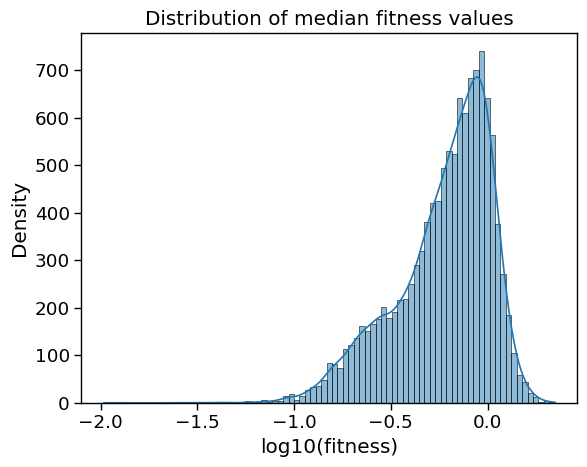

In [ ]:
sns.histplot(np.log10(fitness_by_mutation['median_fitness'].values), kde=True)
plt.xlabel('log10(fitness)')
plt.ylabel('Density')
plt.title("Distribution of median fitness values");

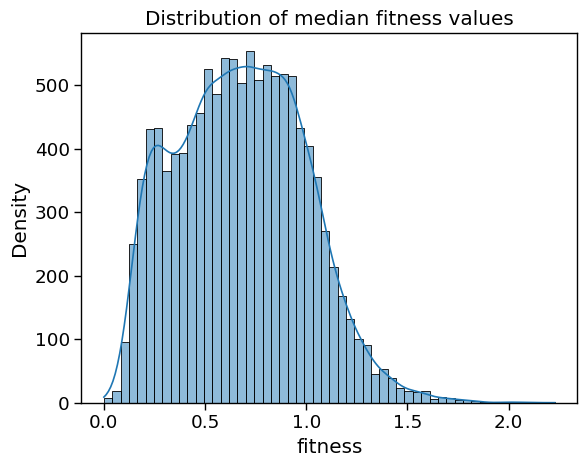

In [ ]:
sns.histplot(fitness_by_mutation['median_fitness'].values, kde=True)
plt.xlabel('fitness')
plt.ylabel('Density')
plt.title("Distribution of median fitness values");

In [ ]:
# median_fitness_wt value is used to normalize the entire dataset
# such that wt fitness corresponds to a value of 1
median_fitness_wt = fitness_by_mutation.loc[-1, 'median_fitness']

sequences = fitness_by_mutation["sequence"].tolist()
fitness = fitness_by_mutation.loc[:, 'median_fitness'].values # obtain target

# transformation to normalize WT fitness value to 1
fitness_norm = (fitness - np.min(fitness))/(median_fitness_wt -np.min(fitness))

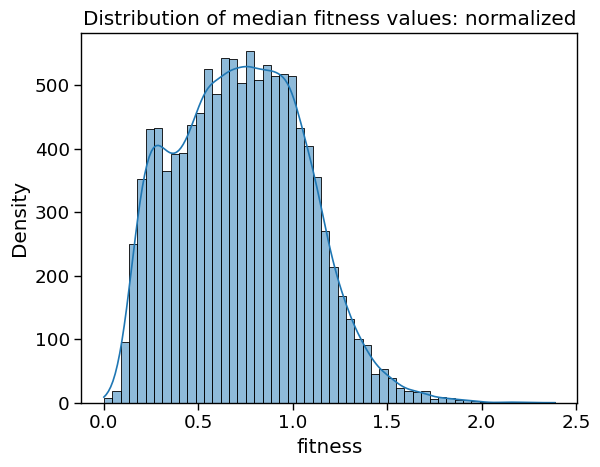

In [ ]:
sns.histplot(fitness_norm, kde=True)
plt.xlabel('fitness')
plt.ylabel('Density')
plt.title("Distribution of median fitness values: normalized");

## Tokenizing the data

All inputs to neural networks must be numerical. The procedure of converting strings into numerical indices, rendering them suitable for neural networks, is termed  **tokenization**. In protein language models, each amino acid is converted to a single token. Every model on `transformers` comes with an associated `tokenizer` that handles tokenization for it. This holds true for protein language models as well.

In [ ]:
esm1v_checkpoint = "facebook/esm1v_t33_650M_UR90S_1"

In [ ]:
# The AutoTokenizer class automatically retrieve the model's configuration, pretrained weights,
# or vocabulary from the name of the checkpoint.
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(esm1v_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# tokenize a single sequence
tokenizer(sequences[0])

{'input_ids': [0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14, 8, 13, 4, 13, 6, 21, 4, 14, 6, 12, 8, 13, 8, 18, 7, 17, 22, 7, 5, 9, 15, 9, 22, 9, 4, 14, 14, 13, 8, 13, 20, 13, 4, 17, 4, 12, 9, 16, 5, 14, 4, 11, 7, 5, 9, 15, 4, 16, 10, 13, 18, 4, 11, 9, 22, 10, 10, 7, 8, 15, 5, 14, 9, 5, 4, 18, 18, 7, 16, 18, 9, 15, 6, 9, 8, 19, 18, 21, 20, 21, 7, 4, 7, 9, 11, 11, 6, 7, 15, 8, 20, 7, 4, 6, 10, 18, 4, 8, 16, 12, 10, 9, 15, 4, 12, 16, 10, 12, 19, 10, 6, 12, 9, 14, 11, 4, 14, 17, 22, 18, 5, 7, 11, 15, 11, 10, 17, 6, 5, 6, 6, 6, 17, 15, 7, 7, 13, 9, 23, 19, 12, 14, 17, 19, 4, 4, 14, 15, 11, 16, 14, 9, 4, 16, 22, 5, 22, 11, 17, 20, 9, 16, 19, 4, 8, 5, 23, 4, 17, 4, 11, 9, 10, 15, 10, 4, 7, 5, 16, 21, 4, 11, 21, 7, 8, 16, 11, 16, 9, 16, 17, 15, 9, 17, 16, 17, 14, 17, 8, 13, 5, 14, 7, 12, 10, 8, 15, 11, 8, 5, 10, 19, 6, 9, 4, 7, 6, 22, 4, 7, 13, 15, 6, 12, 11, 8, 9, 15, 16, 22, 12, 16, 9, 13, 16, 5, 8, 19, 12, 8, 18, 17, 5, 5, 8, 17, 8, 10, 8, 16, 12, 15, 5, 5, 4, 13, 17, 5, 6, 15, 12, 20, 8, 4

Our sequence has been converted into input_ids, which is the tokenized sequence, and an attention_mask. The purpose of the attention mask is to manage variable-length sequences. In instances of shorter sequences, padding is applied using blank "padding" tokens, and the attention mask is padded with 0s, signaling the model to disregard these tokens during processing.

In [ ]:
tokz = tokenizer(sequences)

## Pytorch compatible `Dataset` creation

Our next step involves shaping this data into a dataset compatible with PyTorch. To achieve this, we leverage the HuggingFace `Dataset` class.

In [ ]:
from datasets import Dataset
ds = Dataset.from_dict(tokz)

ds

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 11800
})

In [ ]:
ds = ds.add_column("labels", fitness_norm)
ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 11800
})

In [ ]:
print(ds[0]);

{'input_ids': [0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14, 8, 13, 4, 13, 6, 21, 4, 14, 6, 12, 8, 13, 8, 18, 7, 17, 22, 7, 5, 9, 15, 9, 22, 9, 4, 14, 14, 13, 8, 13, 20, 13, 4, 17, 4, 12, 9, 16, 5, 14, 4, 11, 7, 5, 9, 15, 4, 16, 10, 13, 18, 4, 11, 9, 22, 10, 10, 7, 8, 15, 5, 14, 9, 5, 4, 18, 18, 7, 16, 18, 9, 15, 6, 9, 8, 19, 18, 21, 20, 21, 7, 4, 7, 9, 11, 11, 6, 7, 15, 8, 20, 7, 4, 6, 10, 18, 4, 8, 16, 12, 10, 9, 15, 4, 12, 16, 10, 12, 19, 10, 6, 12, 9, 14, 11, 4, 14, 17, 22, 18, 5, 7, 11, 15, 11, 10, 17, 6, 5, 6, 6, 6, 17, 15, 7, 7, 13, 9, 23, 19, 12, 14, 17, 19, 4, 4, 14, 15, 11, 16, 14, 9, 4, 16, 22, 5, 22, 11, 17, 20, 9, 16, 19, 4, 8, 5, 23, 4, 17, 4, 11, 9, 10, 15, 10, 4, 7, 5, 16, 21, 4, 11, 21, 7, 8, 16, 11, 16, 9, 16, 17, 15, 9, 17, 16, 17, 14, 17, 8, 13, 5, 14, 7, 12, 10, 8, 15, 11, 8, 5, 10, 19, 6, 9, 4, 7, 6, 22, 4, 7, 13, 15, 6, 12, 11, 8, 9, 15, 16, 22, 12, 16, 9, 13, 16, 5, 8, 19, 12, 8, 18, 17, 5, 5, 8, 17, 8, 10, 8, 16, 12, 15, 5, 5, 4, 13, 17, 5, 6, 15, 12, 20, 8, 4

## Transformers as feature extractors

(This section closely follows [Chapter 02 of Natural Language Processing with Transformers book](https://github.com/nlp-with-transformers/notebooks/blob/main/02_classification.ipynb).)

To use transformers as feature extractors, we use the transformers' hidden states as input features and train a classifier on them. We do not modify the pretrained model (the body's weights are frozen during training).

### Using pretrained models

In [ ]:
# Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method
# to load the weights of a pretrained model
from transformers import AutoModel
import torch

esm1v_checkpoint = "facebook/esm1v_t33_650M_UR90S_1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(esm1v_checkpoint).to(device)

pytorch_model.bin:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm1v_t33_650M_UR90S_1 and are newly initialized: ['esm.contact_head.regression.weight', 'esm.pooler.dense.weight', 'esm.contact_head.regression.bias', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warnings are signaling that the model is shedding certain weights related to language modeling (specifically, the lm_head) while incorporating new weights for sequence classification (the classifier). This aligns perfectly with our intention to fine-tune a pretrained language model for a distinct task. The reminder is crucial—it underscores the need to fine-tune the model as it isn't directly usable for inference in its current state.

In this instance, PyTorch is employed to assess the availability of a GPU. Subsequently, we've linked the PyTorch nn.Module.to() method to the model loader. This sequential operation guarantees that the model runs on the GPU if available. In cases where a GPU is absent, the model defaults to CPU, albeit with potentially slower processing speeds.

The AutoModel class is responsible for translating token encodings into embeddings. Subsequently, it propels these embeddings through the encoder stack, ultimately yielding the hidden states.

### Extracting the last hidden states

In [ ]:
# Retrieve the last hidden states for a single string
text = sequences[0]
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 623])


As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.8232,  0.0237, -0.0026,  ..., -0.1937, -0.1018,  0.0266],
         [ 0.1962, -0.0617,  0.0363,  ...,  0.1177, -0.1475, -0.4067],
         [-0.2855, -0.2072,  0.1684,  ..., -0.2313,  0.0847, -0.2179],
         ...,
         [-0.3053, -0.3133,  0.2326,  ..., -0.3441,  0.2464,  0.2063],
         [-0.3412, -0.1370,  0.1844,  ..., -0.3543, -0.0969, -0.0311],
         [-0.1988, -0.1413,  0.3379,  ..., -0.3739, -0.0085,  0.0489]]],
       device='cuda:0'), pooler_output=tensor([[-0.4804,  0.6599,  0.6436,  ...,  0.3077, -0.6117,  0.7320]],
       device='cuda:0'), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 623, 1280])

In [ ]:
outputs.last_hidden_state.mean(dim=1)

tensor([[-0.0589, -0.0359,  0.0045,  ..., -0.1353,  0.0377, -0.0770]],
       device='cuda:0')

In [ ]:
torch.mean(outputs.last_hidden_state, dim=1).size()

torch.Size([1, 1280])

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": torch.mean(last_hidden_state, dim=1).cpu().numpy()}

In [ ]:
ds.set_format("torch",
                        columns=["input_ids", "attention_mask", "labels"])

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# use GPU for this step else very slow
ds = ds.map(extract_hidden_states, batched=True, batch_size = 64)

Map:   0%|          | 0/11800 [00:00<?, ? examples/s]

In [ ]:
with open('data/rep7868aav2_emb_esm1v.pkl', 'wb') as f: pickle.dump(ds, f)

In [ ]:
ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'hidden_state'],
    num_rows: 11800
})

## Splitting the data

In machine learning, the train-test split is a crucial step in model development. It involves dividing the dataset into a training set, used for model training, and a test set, used to assess the model's performance on new, unseen data. This split is essential for gauging how well the model generalizes beyond the training data, preventing overfitting and ensuring robust performance. Cross-validation techniques may also be employed for more robust evaluation, but the train-test split remains a fundamental practice in the machine learning workflow.

In [ ]:
X = np.array(ds["hidden_state"])
y = np.array(ds["labels"])
X.shape, len(y)

((11800, 1280), 11800)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((9440, 1280), (2360, 1280), 9440, 2360)

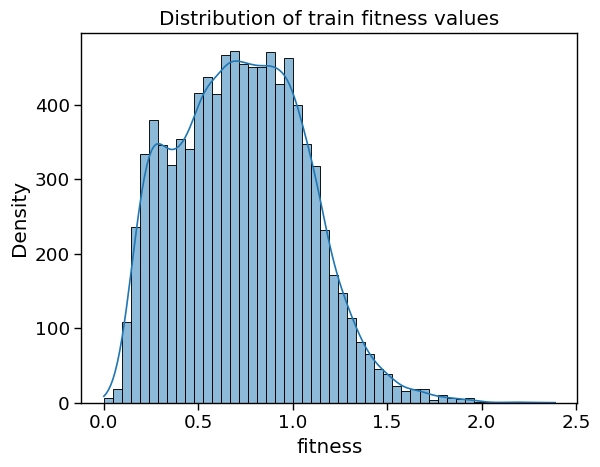

In [ ]:
sns.histplot(y_train, kde=True)
plt.xlabel('fitness')
plt.ylabel('Density')
plt.title("Distribution of train fitness values");

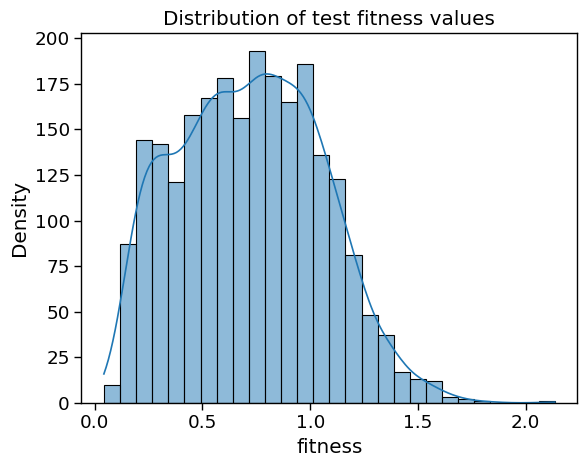

In [ ]:
sns.histplot(y_test, kde=True)
plt.xlabel('fitness')
plt.ylabel('Density')
plt.title("Distribution of test fitness values");

## Visualizing the training set

Prior to training a model on the hidden states, it is advisable to conduct a swift visualization. This step ensures that the the hidden states indeed encapsulate meaningful representation for the sequences we want to classify.

### PCA

PCA, or Principal Component Analysis, is a technique for reducing the dimensionality of data. By transforming original features into uncorrelated variables called principal components, PCA simplifies data representation while retaining key information.

Here, we plot the first two principal components on the x- and y- axes. Each point is then colored by its scaled effect (what we want to predict).

Visually, we can see a separation based on color/effect, suggesting that our representations are useful for this task, without any task-specific training!

In [ ]:
from sklearn.decomposition import PCA
num_pca_components = 60
pca = PCA(num_pca_components)
X_train_pca = pca.fit_transform(X_train)

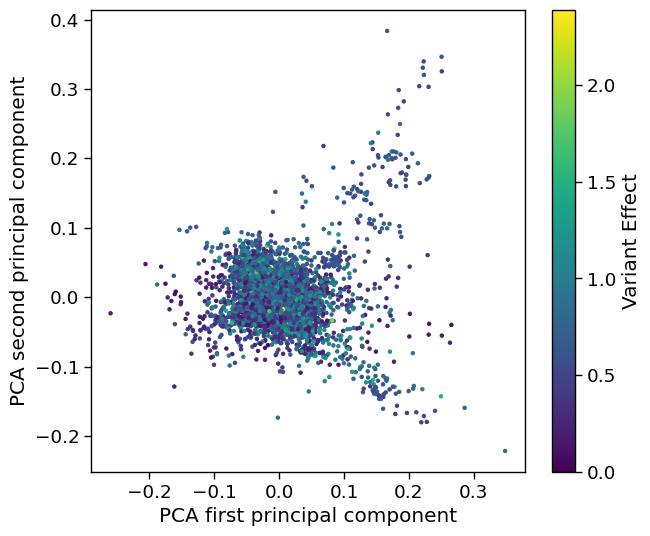

In [ ]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect');

### UMAP

Uniform Manifold Approximation and Projection (UMAP) is a powerful dimensionality reduction technique and manifold learning algorithm. Similar to t-SNE but computationally more efficient, UMAP maps high-dimensional data to a lower-dimensional space while preserving the inherent structure and relationships within the data.

PCA focuses on capturing the maximum variance in the data by finding the principal components, which are linear combinations of the original features. On the other hand, UMAP specializes in preserving local and global structures within the data, making it adept at capturing non-linear relationships.

We use UMAP algorithm to project the vectors down to 2D.

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

def get_umap_embedding(features, umap_params):

    # Initialize UMAP
    reducer = UMAP(random_state=7, **umap_params)
    # Fit UMAP
    mapper = reducer.fit(features)
    embedding = mapper.transform(features)
    return embedding

umap_params = {"n_neighbors": 15, "min_dist": 0.1, "metric": "euclidean"}

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


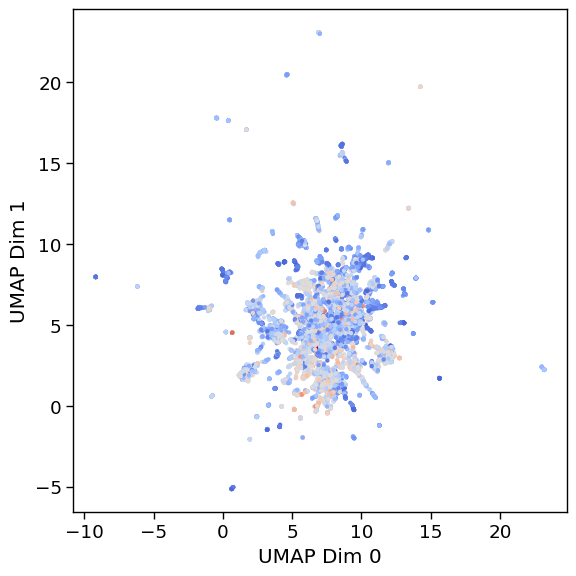

In [ ]:
import matplotlib.colors as colors

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

embedding = get_umap_embedding(X_scaled, umap_params=umap_params)
divnorm = colors.TwoSlopeNorm(vmin=y_train.min(), vcenter=1, vmax=y_train.max())

ax.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap="coolwarm", norm=divnorm,
               s=10.0, alpha=1.0, marker="o", linewidth=0)
ax.set(xlabel="UMAP Dim 0", ylabel="UMAP Dim 1")

plt.tight_layout()
plt.show();

## Training a regressor

### RidgeCV

Ridge. This is L2-penalized linear regression. We used the Python ‘sklearn. linear_model.RidgeCV’ implementation to perform tenfold cross-validation (on the input training data) to select a level of regularization (the parameter α) that minimizes held-out mean squared error. The schedule of regularization strengths was set to be logarithmically spaced from $1 × 10^{−6}$ to $1 × 10^{6}.$

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay, ndcg_score
from sklearn.pipeline import make_pipeline

In [ ]:
%%capture
# different alphas (regularization parameter) to try
alphas = np.logspace(-6, 6, 100)
kfold = KFold(n_splits=5, random_state=42, shuffle=True) # K-Folds cross-validator

# define model
ridgecv = make_pipeline(StandardScaler(),
                           RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=kfold))

# fit model
ridgecv.fit(X_train, y_train)

ridge_best_alpha = ridgecv[1].alpha_

# make predictions
preds_train = ridgecv.predict(X_train)
preds_test = ridgecv.predict(X_test);

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.24409e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.23889e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.17692e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.24409e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

In [ ]:
# Regression
from scipy import stats
spearmanr = stats.spearmanr(a=preds_test, b=y_test, axis=0)
print(spearmanr)

SignificanceResult(statistic=0.7254197401504189, pvalue=0.0)


In [ ]:
print(ridge_best_alpha)

100.0


### RidgeSR

The RidgeSR procedure implemented below has been described in [Low-N protein engineering with data-efficient deep learning](https://www.nature.com/articles/s41592-021-01100-y) paper from Biswas et al, 2021 published in Nature methods.
>Ridge SR: This is the same as the ‘Ridge’ procedure above, except that we additionally perform a post hoc SR procedure. The ‘Ridge’ top model above chooses a level of regularization that optimizes for model generalizability if
the ultimate test distribution (that is, distant regions of the fitness landscape) resembles the training distribution. However, this is not likely the case. Therefore, we performed a post hoc procedure to choose the strongest regularization such that the cross-validation performance was still statistically equal (by t-test) to the level of regularization we would select through normal cross-validation. This procedure selects a stronger regularization than what would be obtained using the ‘Ridge’ procedure as defined above.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [ ]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True) # K-Folds cross-validator
def RidgeSR(best_alpha, X_train, y_train, cv=kfold):
    '''
    Perform a post hoc procedure to choose the strongest regularization such that the
    cross-validation performance was still statistically equal (by t-test) to the level of
    regularization we would select through normal cross-validation. This procedure selects a
    stronger regularization than what would be obtained using the ‘RidgeCV’ procedure implemented before.

    Input:
    `best_alpha`: best regularization parameter alpha from RidgeCV procedure
    '''
    alphas = np.linspace(best_alpha, best_alpha*20, 20)
    ridge = make_pipeline(StandardScaler(),
                       Ridge())

    p_values = []
    mse = []

    for a in alphas:
        ridge[1].set_params(alpha = a)
        scores_posthoc = cross_val_score(ridge, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1)
        scores_posthoc = np.absolute(scores_posthoc)

        if a == best_alpha: scores = scores_posthoc

        mse.append(np.mean(scores_posthoc))
        p_values.append(stats.ttest_ind(scores, scores_posthoc).pvalue)

    # choose alpha higher than best alpha
    # choose a stronger alpha than would be selected by RidgeCV such that cross validation performance
    # is still equal to best alpha from RidgeCV
    # When p value < 0.10 MSE distribution from stronger alpha is considered the same as from best alpha
    alpha_ridgsesr = alphas[np.where(1-np.asarray(p_values) <= 0.90)[0][-1]]
    mse_ridgesr = mse[np.where(1-np.asarray(p_values) <= 0.90)[0][-1]]

    # Plot alpha vs MSE and alpha vs p-value
    fig, (ax0, ax1) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

    ax0.plot(alphas, mse, 'ro-')
    ax0.set(xlabel='alphas', ylabel='mean squared error')

    ax1.plot(alphas, p_values, 'bo-')
    ax1.set(xlabel='alphas', ylabel='p value')

    fig.suptitle(f'RidgeSR alpha: {alpha_ridgsesr}')

    plt.tight_layout()
    plt.show();

    return alpha_ridgsesr

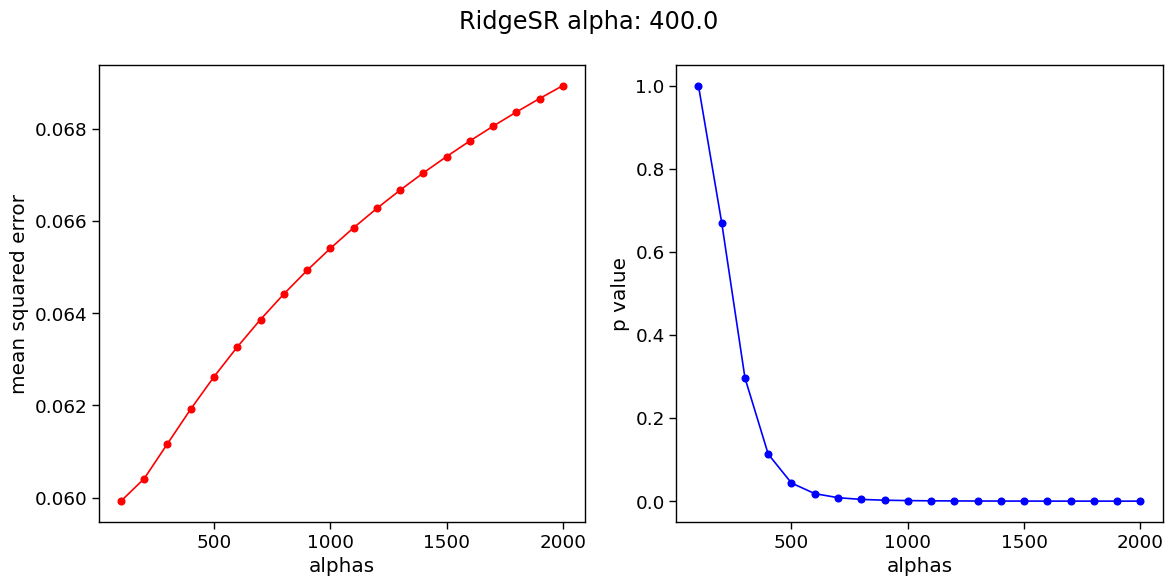

In [ ]:
# best alpha from RidgeCV procedure
best_alpha = ridge_best_alpha

# selects a stronger regularization than what would be obtained using the ‘RidgeCV’ procedure previously defined
ridgsesr_alpha = RidgeSR(best_alpha, X_train, y_train, cv=kfold)

# define model
ridge = make_pipeline(StandardScaler(),
                           Ridge(alpha=ridgsesr_alpha))

# fit model
ridge.fit(X_train, y_train)

# make predictions
preds_train = ridge.predict(X_train)
preds_test = ridge.predict(X_test)

In [ ]:
print(stats.spearmanr(a=preds_test, b=y_test, axis=0))

SignificanceResult(statistic=0.7156659724956432, pvalue=0.0)


In [ ]:
print(ridgsesr_alpha)

400.0


### Bagging Regressor

The Bagging Regressor or Ensembled Ridge SR procedure implemented below has been described in [Low-N protein engineering with data-efficient deep learning](https://www.nature.com/articles/s41592-021-01100-y) paper from Biswas et al, 2021 published in Nature methods.

>Ensembled Ridge SR: This is the same as the ‘Ridge SR’ procedure above, except that the final top model is an ensemble of Ridge SR top models. The ensemble is composed of 100 members. Each member (a Ridge SR top model) is fit to a bootstrap of the training data (N training points are resampled N times with replacement) and a random subset of the features. The final prediction is an average of all members in the ensemble. The rationale for this approach is
that it is based on consensus of many different Ridge SR models that have different ‘hypotheses’ for how sequence might influence function. Differences in these ‘hypotheses’ are driven by the fact that every bootstrap represents a different plausible instantiation of the training data and that every random subsample of features represents different variables that could influence function.

In [ ]:
from sklearn.ensemble import BaggingRegressor

# define ridge model with RidgeSR alpha
ridge = make_pipeline(StandardScaler(),
                       Ridge(alpha=ridgsesr_alpha))

# define bag model
bag = BaggingRegressor(estimator=ridge,
                       n_estimators=100,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=-1)

# fit the data
bag.fit(X_train, y_train)

# make predictions
preds_train = bag.predict(X_train)
preds_test = bag.predict(X_test)

In [ ]:
spearmanr = stats.spearmanr(a=preds_test, b=y_test, axis=0)
print(spearmanr)

SignificanceResult(statistic=0.7144792120843033, pvalue=0.0)


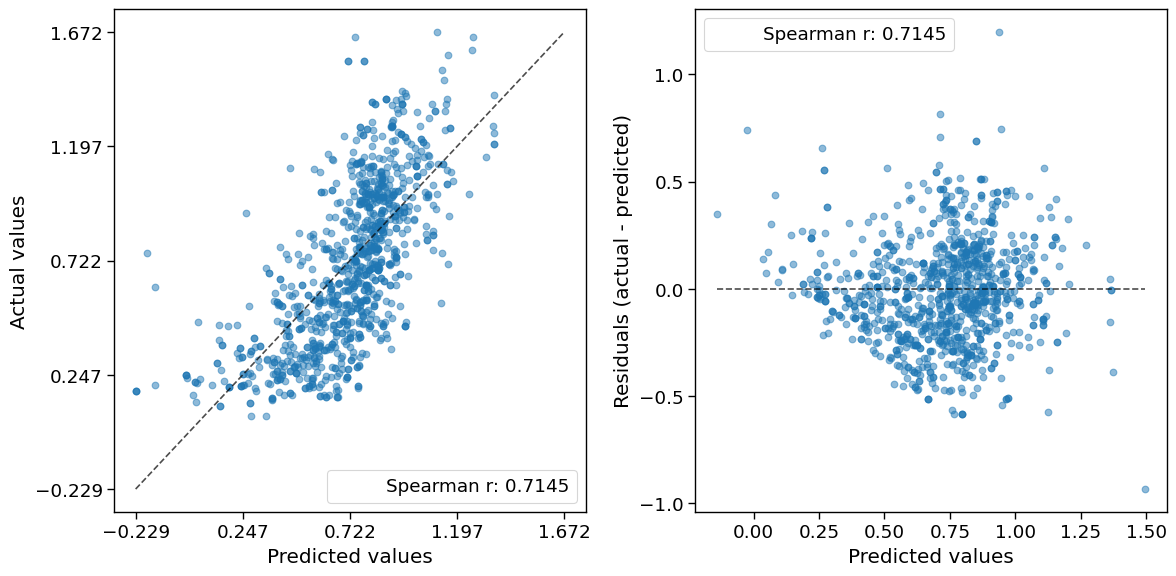

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
fig, (ax0, ax1) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

# plot actual vs predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    preds_test,
    ax=ax0,
    kind='actual_vs_predicted',
    scatter_kwargs={"alpha":0.5}
)
ax0.plot([], [], " ", label=f"Spearman r: {np.round(spearmanr.statistic, 4)}")
ax0.legend(loc="best")
ax0.axis('tight')

PredictionErrorDisplay.from_predictions(
    y_test,
    preds_test,
    kind='residual_vs_predicted',
    ax=ax1,
    scatter_kwargs={"alpha":0.5}
)

ax1.plot([], [], " ", label=f"Spearman r: {np.round(spearmanr.statistic, 4)}")
ax1.legend(loc="best")
ax1.axis('tight')

plt.tight_layout()
plt.show();

### Bagging Regressor on entire data

Final model for prediction on single and multiple mutants.

In [ ]:
# define ridge model with RidgeSR alpha
ridge = make_pipeline(StandardScaler(),
                       Ridge(alpha=ridgsesr_alpha))

# define bag model
bag_emb_esm1v = BaggingRegressor(estimator=ridge,
                       n_estimators=100,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       oob_score=True,
                       n_jobs=-1)

# No train test split. Fit the bag model on entire dataset
bag_emb_esm1v.fit(X, y)

# make predictions
preds_oob_esm1v = bag_emb_esm1v.oob_prediction_

! mkdir -p models

# save model
with open('models/bag_emb_esm1v_rep7868aav2.pkl','wb') as f:
    pickle.dump(bag_emb_esm1v,f)

In [ ]:
print(stats.spearmanr(a=preds_oob_esm1v, b=y, axis=0))

SignificanceResult(statistic=0.7178772755854543, pvalue=0.0)


## Potential hits from the model

The model is now ready for inference. We can now use the model to identify promising protein sequence variants for experimental validation.

In [ ]:
ds_with_preds = ds.add_column("predicted_label", preds_oob_esm1v)
ds_with_preds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'hidden_state', 'predicted_label'],
    num_rows: 11800
})

In [ ]:
# create a DataFrame with the input_ids, losses, and predicted/true labels:
ds_with_preds.set_format("pandas")
cols = ['input_ids', 'labels', 'predicted_label']
df_with_preds = ds_with_preds[:][cols]

In [ ]:
df_with_preds.head()

,input_ids,labels,predicted_label
0,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.000000,0.790839
1,"[0, 5, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14,...",0.898696,0.714119
2,"[0, 23, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.680702,0.884781
3,"[0, 13, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.511988,0.806718
4,"[0, 9, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14,...",0.788339,0.658499


In [ ]:
# Load the Rep78 DMS data for supervised training saved as pkl file
# with open('data/fitness_by_mutation_rep7868aav2.pkl', 'rb') as f: fitness_by_mutation = pickle.load(f)
sequences = fitness_by_mutation["sequence"].tolist()

In [ ]:
df_with_preds['sequence'] = sequences
df_with_preds.head()

,input_ids,labels,predicted_label,sequence
0,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.000000,0.790839,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...
1,"[0, 5, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14,...",0.898696,0.714119,APGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...
2,"[0, 23, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.680702,0.884781,CPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...
3,"[0, 13, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.511988,0.806718,DPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...
4,"[0, 9, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14,...",0.788339,0.658499,EPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...


In [ ]:
from functools import partial
def find_mutated_aa(best_seq, starter_seq):
    """Return aminoacid substitution between two protein sequences of the same length"""
    mutated_aa = [starter_seq[i]+str(i+1)+best_seq[i] for i in range(len(starter_seq))
                  if starter_seq[i] != best_seq[i]]
    return mutated_aa

mut_in_rep78 = partial(find_mutated_aa, starter_seq=wt_seq)

In [ ]:
df_with_preds['mutated_aa'] = df_with_preds['sequence'].apply(mut_in_rep78)
df_with_preds

,input_ids,labels,predicted_label,sequence,mutated_aa
0,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.000000,0.790839,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[]
1,"[0, 5, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14,...",0.898696,0.714119,APGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[M1A]
2,"[0, 23, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.680702,0.884781,CPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[M1C]
3,"[0, 13, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.511988,0.806718,DPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[M1D]
4,"[0, 9, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14,...",0.788339,0.658499,EPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[M1E]
...,...,...,...,...,...
11795,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.154430,0.825667,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[Q621S]
11796,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.994726,0.816381,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[Q621T]
11797,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.065038,0.903975,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[Q621V]
11798,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.826328,0.917002,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[Q621W]


In [ ]:
df_with_preds.sort_values(by = ['predicted_label', 'labels'], ascending = [False, False]).head(100)

,input_ids,labels,predicted_label,sequence,mutated_aa
10072,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.887348,1.522289,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[Q531C]
11763,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.974105,1.422043,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[E620C]
9480,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.141740,1.420908,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[D499W]
227,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 22...",0.749180,1.418258,MPGFYEIVIKVWSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[P12W]
9708,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.064671,1.410387,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[S511W]
...,...,...,...,...,...
2370,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.271920,1.216066,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[E125R]
211,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 23...",1.877407,1.215950,MPGFYEIVIKVCSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[P12C]
986,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",0.925774,1.215368,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,[P52V]
662,"[0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14...",1.102618,1.214111,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKESELPPDSDMDLN...,[W35S]


In [ ]:
df_with_preds.sort_values(by = ['predicted_label', 'labels'],
                               ascending = [False, False]).to_csv('data/rep7868aav2_preds_emb_esm1v.csv')

The model can additionally serve for prospective design by generating sequence proposals through in silico directed evolution. The exploration of in silico directed evolution will be delved into in a future notebook. In part two of this notebook, we will develop a complementary approach for sequence-to-function modeling on deep mutational scanning data: one relying fine-tuning pretrained protein langauge model.

## Please don’t fall into blind love with models' elegance and power

I would like to end this notebook with an excerpt from Richard McElreath's book Statistical Rethinking about statistical models:

> Scientists also make golems. Our golems rarely have physical form, but they too are often made of clay, living in silicon as computer code. These golems are scientific model. But these golems have real effects on the world, through the predictions they make and the intuitions they challenge or inspire. A concern with truth enlivens these models, but just like a golem or a modern robot, scientific models are neither true nor false, neither prophets nor charlatans. Rather they are constructs engineered for some purpose. These constructs are incredibly powerful, dutifully conducting their programmed calculations

In the context of model inference, it is imperative to prioritize scientific rigor over statistical outcomes. A thorough comprehension of the data generation process, acknowledgment of model limitations, and an understanding of the distribution within the inference regime are essential. Consideration of specific experimental details is paramount:

1) **Assay fidelity vs Assay throughput**:
One practical application of the [DMS data](https://raw.githubusercontent.com/churchlab/aav_rep_scan/master/analysis/selection_values/wtaav2_selection_values_barcode.csv) from [rep mutagenesis scan paper published in 2023 from George M. Church lab](https://doi.org/10.7554/eLife.87730.1) is to improve recombinant adeno-associated virus (rAAV) production for therapeutic purposes. rAAV production is carefully measured using viral genome titer assay (high fidelity, low throughput assay). Deep  mutational scanning experiments use  a  high-throughput assay to screen an initial variant library and isolate variants with a desired functional property. The initial library and the isolated variants are sequenced, and a fitness score is computed for each variant based on the frequency of reads in both sets. The fitness score from low fidelity high throughput assay are only a proxy measurement for the viral genome titer we want to optimize for.

2) **Role of Data Quality in Learning Accurate Sequence-function Models**:
The accuracy of the computed fitness scores hinges on the  sensitivity  and specificity of the high-throughput assay, the number of times each variant was characterized in the high-throughput assay, and the number of DNA sequencing reads per variant. In cases where any of these factors is insufficient, the resultant fitness scores may not accurately represent the genuine fitness values of the characterized proteins. This discrepancy complicates the task of training a model to grasp the underlying sequence-to-function mapping. Hence, practical considerations such as the size and quality of the DMS dataset could influence protein-specific performance.

3) **Design of the study**:
The paper could have additionally enriched for high fitness variants by performing transduction with isolated AAV particles.

4) **Sequence-to-function modeling complexity**:
The protein sequence-to-function model faces complexity due to the necessity to capture non-additive effects (epistasis) and the challenge of generalizing to unseen mutations, spanning from low-order to higher-order mutations.

In [ ]:
# Download model
from google.colab import files
files.download("models/bag_emb_esm1v_rep7868aav2.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!md5sum models/bag_emb_esm1v_rep7868aav2.pkl

b2adfa4cf9be0b8614ab2b0c6aeee622  models/bag_emb_esm1v_rep7868aav2.pkl


In [ ]:
# download all files from colab data folder
!zip -r /content/data.zip /content/data
files.download('/content/data.zip')


updating: content/data/ (stored 0%)
updating: content/data/rep7868aav2_emb_esm1v.pkl (deflated 42%)
updating: content/data/fitness_by_mutation_rep7868aav2.pkl (deflated 84%)
updating: content/data/rep7868aav2_preds_emb_esm1v.csv (deflated 98%)
updating: content/data/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>